# Model21: one more

In [1]:
from utils import load_buzz, select, write_result
from features import featurize, get_pos
from containers import Questions, Users, Categories
from nlp import extract_entities

## GMM

### Classifying questions
features: avg_pos, accuracy rate

In [50]:
%matplotlib inline
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture


def plot_gmm(X, models, n_components, covariance_type='diag', n_iter=100,
            figsize=(10, 20), suptitle=None, xlabel=None, ylabel=None):
    color_iter = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'gray', 'pink', 'lime']
    plt.figure(figsize=figsize)
    plt.suptitle(suptitle, fontsize=20)

    for i, model in enumerate(models):
        mm = getattr(mixture, model)(n_components=n_components,
                                     covariance_type=covariance_type,
                                     n_iter=n_iter)
        mm.fit(X_pos_qid)
        Y = mm.predict(X_pos_qid)

        plt.subplot(len(models), 1, 1 + i)
        for i, color in enumerate(color_iter):
            plt.scatter(X_pos_qid[Y == i, 0], X_pos_qid[Y == i, 1], .7, color=color)
        plt.title(model, fontsize=15)
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel(ylabel, fontsize=12)
        plt.grid()

    plt.show()

In [51]:
import pickle

questions = pickle.load(open('questions01.pkl', 'rb'))
users = pickle.load(open('users01.pkl', 'rb'))
categories = pickle.load(open('categories01.pkl', 'rb'))

In [52]:
X_pos_uid = users.select(['ave_pos_uid', 'acc_ratio_uid'])
X_pos_qid = questions.select(['ave_pos_qid', 'acc_ratio_qid', 'ne_nor_mean', 'ne_mean', 'ne_median'])

In [53]:
X_pos_qid[0]

array([ 70.5       ,   0.875     ,   0.72435897,  56.5       ,  60.5       ])

In [54]:
from sklearn.preprocessing import normalize

X_pos_uid = normalize(X_pos_uid, norm='l1')
X_pos_qid = normalize(X_pos_qid, norm='l1')

In [55]:
print(X_pos_qid[0])
print(X_pos_uid[0])

[ 0.37281988  0.0046272   0.00383057  0.29878473  0.31993763]
[ 0.98978868  0.01021132]


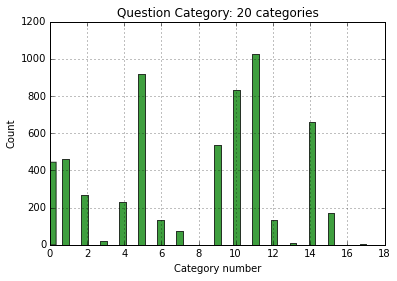

In [56]:
# Question category
n_components = 20
gmm = mixture.GMM(n_components=n_components, covariance_type='diag', n_iter=10**10)
gmm.fit(X_pos_qid)
pred_cat_qid = gmm.predict(X_pos_qid)

plt.hist(pred_cat_qid, bins=50, facecolor='g', alpha=0.75)
plt.xlabel("Category number")
plt.ylabel("Count")
plt.title("Question Category: " + str(n_components) + " categories")
plt.grid(True)
plt.show()

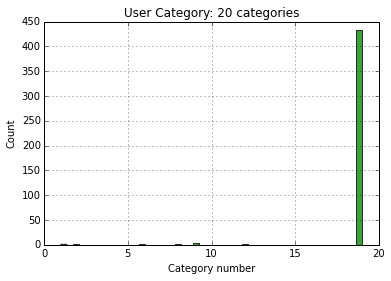

In [57]:
# User category
n_components = 20
gmm = mixture.GMM(n_components=n_components, covariance_type='diag', n_iter=10**10)
gmm.fit(X_pos_uid)
pred_cat_uid = gmm.predict(X_pos_uid)

plt.hist(pred_cat_uid, bins=50, facecolor='g', alpha=0.75)
plt.xlabel("Category number")
plt.ylabel("Count")
plt.title("User Category: " + str(n_components) + " categories")
plt.grid(True)
plt.show()

In [58]:
from collections import Counter


users.sub_append('cat_uid', {key: str(pred_cat_uid[i]) for i, key in enumerate(users.keys())})
questions.sub_append('cat_qid', {key: str(pred_cat_qid[i]) for i, key in enumerate(questions.keys())})

# to get most frequent cat for some test data which do not have ids in train set
most_pred_cat_uid = Counter(pred_cat_uid).most_common(1)[0][0]
most_pred_cat_qid = Counter(pred_cat_qid).most_common(1)[0][0]

print(most_pred_cat_uid)
print(most_pred_cat_qid)

19
11


In [59]:
print(users.sub_keys())
print(questions.sub_keys())

dict_keys(['ave_pos_uid', 'cat_uid', 'acc_ratio_uid'])
dict_keys(['ne_nor_mean', 'ne_mean', 'ne_median', 'ave_pos_qid', 'group', 'question', 'pos_token', 'answer', 'acc_ratio_qid', 'category', 'cat_qid', 'ne_count', 'ne_tags', 'ne_mod'])


## B. Modeling

In [71]:
def add_features(X):
    for item in X:
        # category
        for key in categories[item['category']].keys():
            item[key] = categories[item['category']][key]
            
        uid = int(item['uid'])
        qid = int(item['qid'])
        
        # uid
        if int(uid) in users:
            item.update(users[uid])
        else:
            acc = users.select(['acc_ratio_uid'])
            item['acc_ratio_uid'] = sum(acc) / float(len(acc))
            item['cat_uid'] = most_pred_cat_uid

        # qid
        if int(qid) in questions:
            item.update(questions[qid])

In [72]:
X_train, y_train = featurize(load_buzz(), group='train', sign_val=None, extra=['sign_val', 'avg_pos'])
add_features(X_train)

In [73]:
unwanted_features = ['ne_tags', 'pos_token', 'question', 'sign_val', 'group']
wanted_features = list(set(X_train[1].keys()) - set(unwanted_features))
wanted_features

['q_length',
 'ave_pos_cat',
 'ave_pos_qid',
 'avg_pos_qid',
 'acc_ratio_cat',
 'uid',
 'category',
 'ave_pos_uid',
 'ne_count',
 'ne_nor_mean',
 'ne_mean',
 'ne_median',
 'avg_pos_uid',
 'ne_mod',
 'cat_uid',
 'answer',
 'acc_ratio_qid',
 'cat_qid',
 'acc_ratio_uid',
 'qid']

In [74]:
X_train = select(X_train, wanted_features)
X_train[1]

{'acc_ratio_cat': 0.7560975609756098,
 'acc_ratio_qid': 0.875,
 'acc_ratio_uid': 0.6465863453815262,
 'answer': 'thomas cole',
 'ave_pos_cat': 43.640185830429736,
 'ave_pos_qid': 70.5,
 'ave_pos_uid': 96.724899598393577,
 'avg_pos_qid': 51.0,
 'avg_pos_uid': 30.973895582329316,
 'cat_qid': '11',
 'cat_uid': '19',
 'category': 'Fine Arts',
 'ne_count': 12,
 'ne_mean': 56.5,
 'ne_median': 60.5,
 'ne_mod': 65,
 'ne_nor_mean': 0.7243589743589743,
 'q_length': 78,
 'qid': 1,
 'uid': 1}

In [75]:
from sklearn.feature_extraction import DictVectorizer


vec = DictVectorizer()
X_train_dict_vec = vec.fit_transform(X_train)

In [84]:
import multiprocessing
from sklearn import linear_model
from sklearn.cross_validation import ShuffleSplit, cross_val_score
import math
from numpy import abs, sqrt


regressor_names = """
ElasticNetCV
"""
n_samples = X_train_dict_vec.shape[0]
cv = ShuffleSplit(n_samples, n_iter=5, test_size=0.2, random_state=50)
for l1 in [0.72]:
    print ("=== ElasticNetCV RMSE", "with", l1)
    for regressor in regressor_names.split():
        scores = cross_val_score(getattr(linear_model, regressor)(n_jobs=3, normalize=True, l1_ratio = l1),
                                 X_train_dict_vec, y_train,
                                 cv=cv,
                                 scoring='mean_squared_error'
                                )
        print (regressor, sqrt(abs(scores)).mean())

=== ElasticNetCV RMSE with 0.72
ElasticNetCV 75.0452245435


### Training and testing model

In [66]:
X_test = featurize(load_buzz(), group='test', sign_val=None, extra=['avg_pos'])
add_features(X_test)
X_test = select(X_test, wanted_features)

WARN: no key question
WARN: no key pos_token
WARN: no key ne_tags
WARN: no key question
WARN: no key pos_token
WARN: no key ne_tags
WARN: no key question
WARN: no key pos_token
WARN: no key ne_tags
WARN: no key question
WARN: no key pos_token
WARN: no key ne_tags
WARN: no key question
WARN: no key pos_token
WARN: no key ne_tags
WARN: no key question
WARN: no key pos_token
WARN: no key ne_tags
WARN: no key question
WARN: no key pos_token
WARN: no key ne_tags
WARN: no key question
WARN: no key pos_token
WARN: no key ne_tags
WARN: no key question
WARN: no key pos_token
WARN: no key ne_tags
WARN: no key question
WARN: no key pos_token
WARN: no key ne_tags
WARN: no key question
WARN: no key pos_token
WARN: no key ne_tags
WARN: no key question
WARN: no key pos_token
WARN: no key ne_tags
WARN: no key question
WARN: no key pos_token
WARN: no key ne_tags
WARN: no key question
WARN: no key pos_token
WARN: no key ne_tags
WARN: no key question
WARN: no key pos_token
WARN: no key ne_tags
WARN: no k

In [67]:
X_train[1]

{'acc_ratio_cat': 0.7560975609756098,
 'acc_ratio_qid': 0.875,
 'acc_ratio_uid': 0.6465863453815262,
 'answer': 'thomas cole',
 'ave_pos_cat': 43.640185830429736,
 'ave_pos_qid': 70.5,
 'ave_pos_uid': 96.724899598393577,
 'avg_pos_qid': 51.0,
 'avg_pos_uid': 30.973895582329316,
 'cat_qid': '11',
 'cat_uid': '19',
 'category': 'Fine Arts',
 'group': 'test',
 'ne_count': 12,
 'ne_mean': 56.5,
 'ne_median': 60.5,
 'ne_mod': 65,
 'ne_nor_mean': 0.7243589743589743,
 'q_length': 78,
 'qid': 1,
 'uid': 1}

In [68]:
X_test[1]

{'acc_ratio_cat': 0.65625,
 'acc_ratio_qid': 0.6428571428571429,
 'acc_ratio_uid': 0.6712328767123288,
 'answer': 'david hilbert',
 'ave_pos_cat': 18.712499999999999,
 'ave_pos_qid': 79.857142857142861,
 'ave_pos_uid': 98.863013698630141,
 'avg_pos_qid': 15.571428571428571,
 'avg_pos_uid': 36.31506849315068,
 'cat_qid': '9',
 'cat_uid': '19',
 'category': 'Mathematics',
 'group': 'train',
 'ne_count': 9,
 'ne_mean': 85.11111111111111,
 'ne_median': 97.0,
 'ne_mod': 97,
 'ne_nor_mean': 0.8105820105820106,
 'q_length': 105,
 'qid': 9967,
 'uid': 131}

In [69]:
vec = DictVectorizer()
vec.fit(X_train + X_test)
X_train = vec.transform(X_train)
X_test = vec.transform(X_test)

In [70]:
for l1_ratio in [0.7, 0.72]:
    print('=== l1_ratio:', l1_ratio)
    regressor = linear_model.ElasticNetCV(n_jobs=3, normalize=True, l1_ratio=l1_ratio)
    regressor.fit(X_train, y_train)
    print(regressor.coef_)
    print(regressor.alpha_)
    predictions = regressor.predict(X_test)
    write_result(load_buzz()['test'], predictions, file_name=str(l1_ratio)+'guess_adj.csv', adj=True)

=== l1_ratio: 0.7
[  1.56247575e+01   2.90232147e+01   2.64921982e+01 ...,   2.81880926e-02
   3.65649402e-06  -4.03491259e-03]
0.000404215283508
** Adjust results ***
** tid qid uid: pred_pos, q_length, diff
32193 123840 15 : 34.637656383536715 , 33 , 1.637656383536715
32186 123840 28 : 35.24361207333974 , 33 , 2.24361207333974
32081 123757 1 : 35.36257254320609 , 29 , 6.362572543206092
32067 123750 43 : 26.129213860954515 , 19 , 7.129213860954515
32025 123718 39 : 19.960609291697644 , 13 , 6.960609291697644
32018 123718 13 : 21.105819699128908 , 13 , 8.105819699128908
31997 123709 52 : 33.041388302617 , 17 , 16.041388302617
13083 106213 9 : 36.20669745120626 , 21 , 15.20669745120626
1232 674 161 : 48.29184378264163 , 48 , 0.291843782641628
24990 106373 62 : 30.709411600779525 , 23 , 7.709411600779525

** diff_tot 71.68882498910803
=== l1_ratio: 0.72
[  1.56485094e+01   3.06933469e+01   2.79998630e+01 ...,   2.92317049e-02
   3.56475447e-06  -4.00410242e-03]
0.000392987081188
** Adjus